In [1]:
from utils.Auger.SD import Monitoring

09:20:02 (  +924ms) [INFO   ] -- import logging
09:20:02 (   +94ms) [INFO   ] -- import numpy as np
09:20:02 (    +9ms) [INFO   ] -- import uncertainties
09:20:02 (  +238ms) [INFO   ] -- import pandas as pd
09:20:02 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
09:20:02 (    +2ms) [INFO   ] -- import binaries.tools as tools


In [2]:
monitoring = Monitoring.Monit('/cr/data01/filip/Data/daqIntegrationTests/v13/mc_2024_09_14_00h00.root')

09:20:03 (   +46ms) [INFO   ] -- received 1 file(s) as input
09:20:03 (   +99ms) [INFO   ] -- View monit keys with self.keys()


In [3]:
monitoring.keys()

{
  "TObject": {
    "fUniqueID": "TObject/fUniqueID",
    "fBits": "TObject/fBits"
  },
  "fLsId": "fLsId",
  "fTime": "fTime",
  "fCDASTime": "fCDASTime",
  "fMonitoring": {
    "fIsMonitoring": "fMonitoring/fMonitoring.fIsMonitoring",
    "fIsUUB": "fMonitoring/fMonitoring.fIsUUB",
    "fPMV": "fMonitoring/fMonitoring.fPMV[3]",
    "fPMI": "fMonitoring/fMonitoring.fPMI[3]",
    "fPMT": "fMonitoring/fMonitoring.fPMT[3]",
    "fElectT": "fMonitoring/fMonitoring.fElectT",
    "fBatteryT[2]": "fMonitoring/fMonitoring.fBatteryT[2]",
    "fBatteryV[2]": "fMonitoring/fMonitoring.fBatteryV[2]",
    "fCurrentLoad": "fMonitoring/fMonitoring.fCurrentLoad",
    "fSolarPanelV": "fMonitoring/fMonitoring.fSolarPanelV",
    "fSolarPanelI": "fMonitoring/fMonitoring.fSolarPanelI",
    "fWaterLevel": "fMonitoring/fMonitoring.fWaterLevel",
    "fWaterT": "fMonitoring/fMonitoring.fWaterT",
    "f12VRadio": "fMonitoring/fMonitoring.f12VRadio",
    "f3V": "fMonitoring/fMonitoring.f3V",
    "f_3V": "fMonit

In [4]:
t = monitoring('fTime', 136)
vem = monitoring('fPeak', 136)
t70 = monitoring('f70HzRate', 136)
mask = [True if v[-1] != 0 else False for v in vem]
# mask = [True for v in vem]

09:20:03 (  +122ms) [INFO   ] -- found 1079 entries for key fTime and station #136
09:20:03 (   +21ms) [INFO   ] -- found 1079 entries for key fPeak and station #136
09:20:03 (   +61ms) [INFO   ] -- found 1079 entries for key f70HzRate and station #136


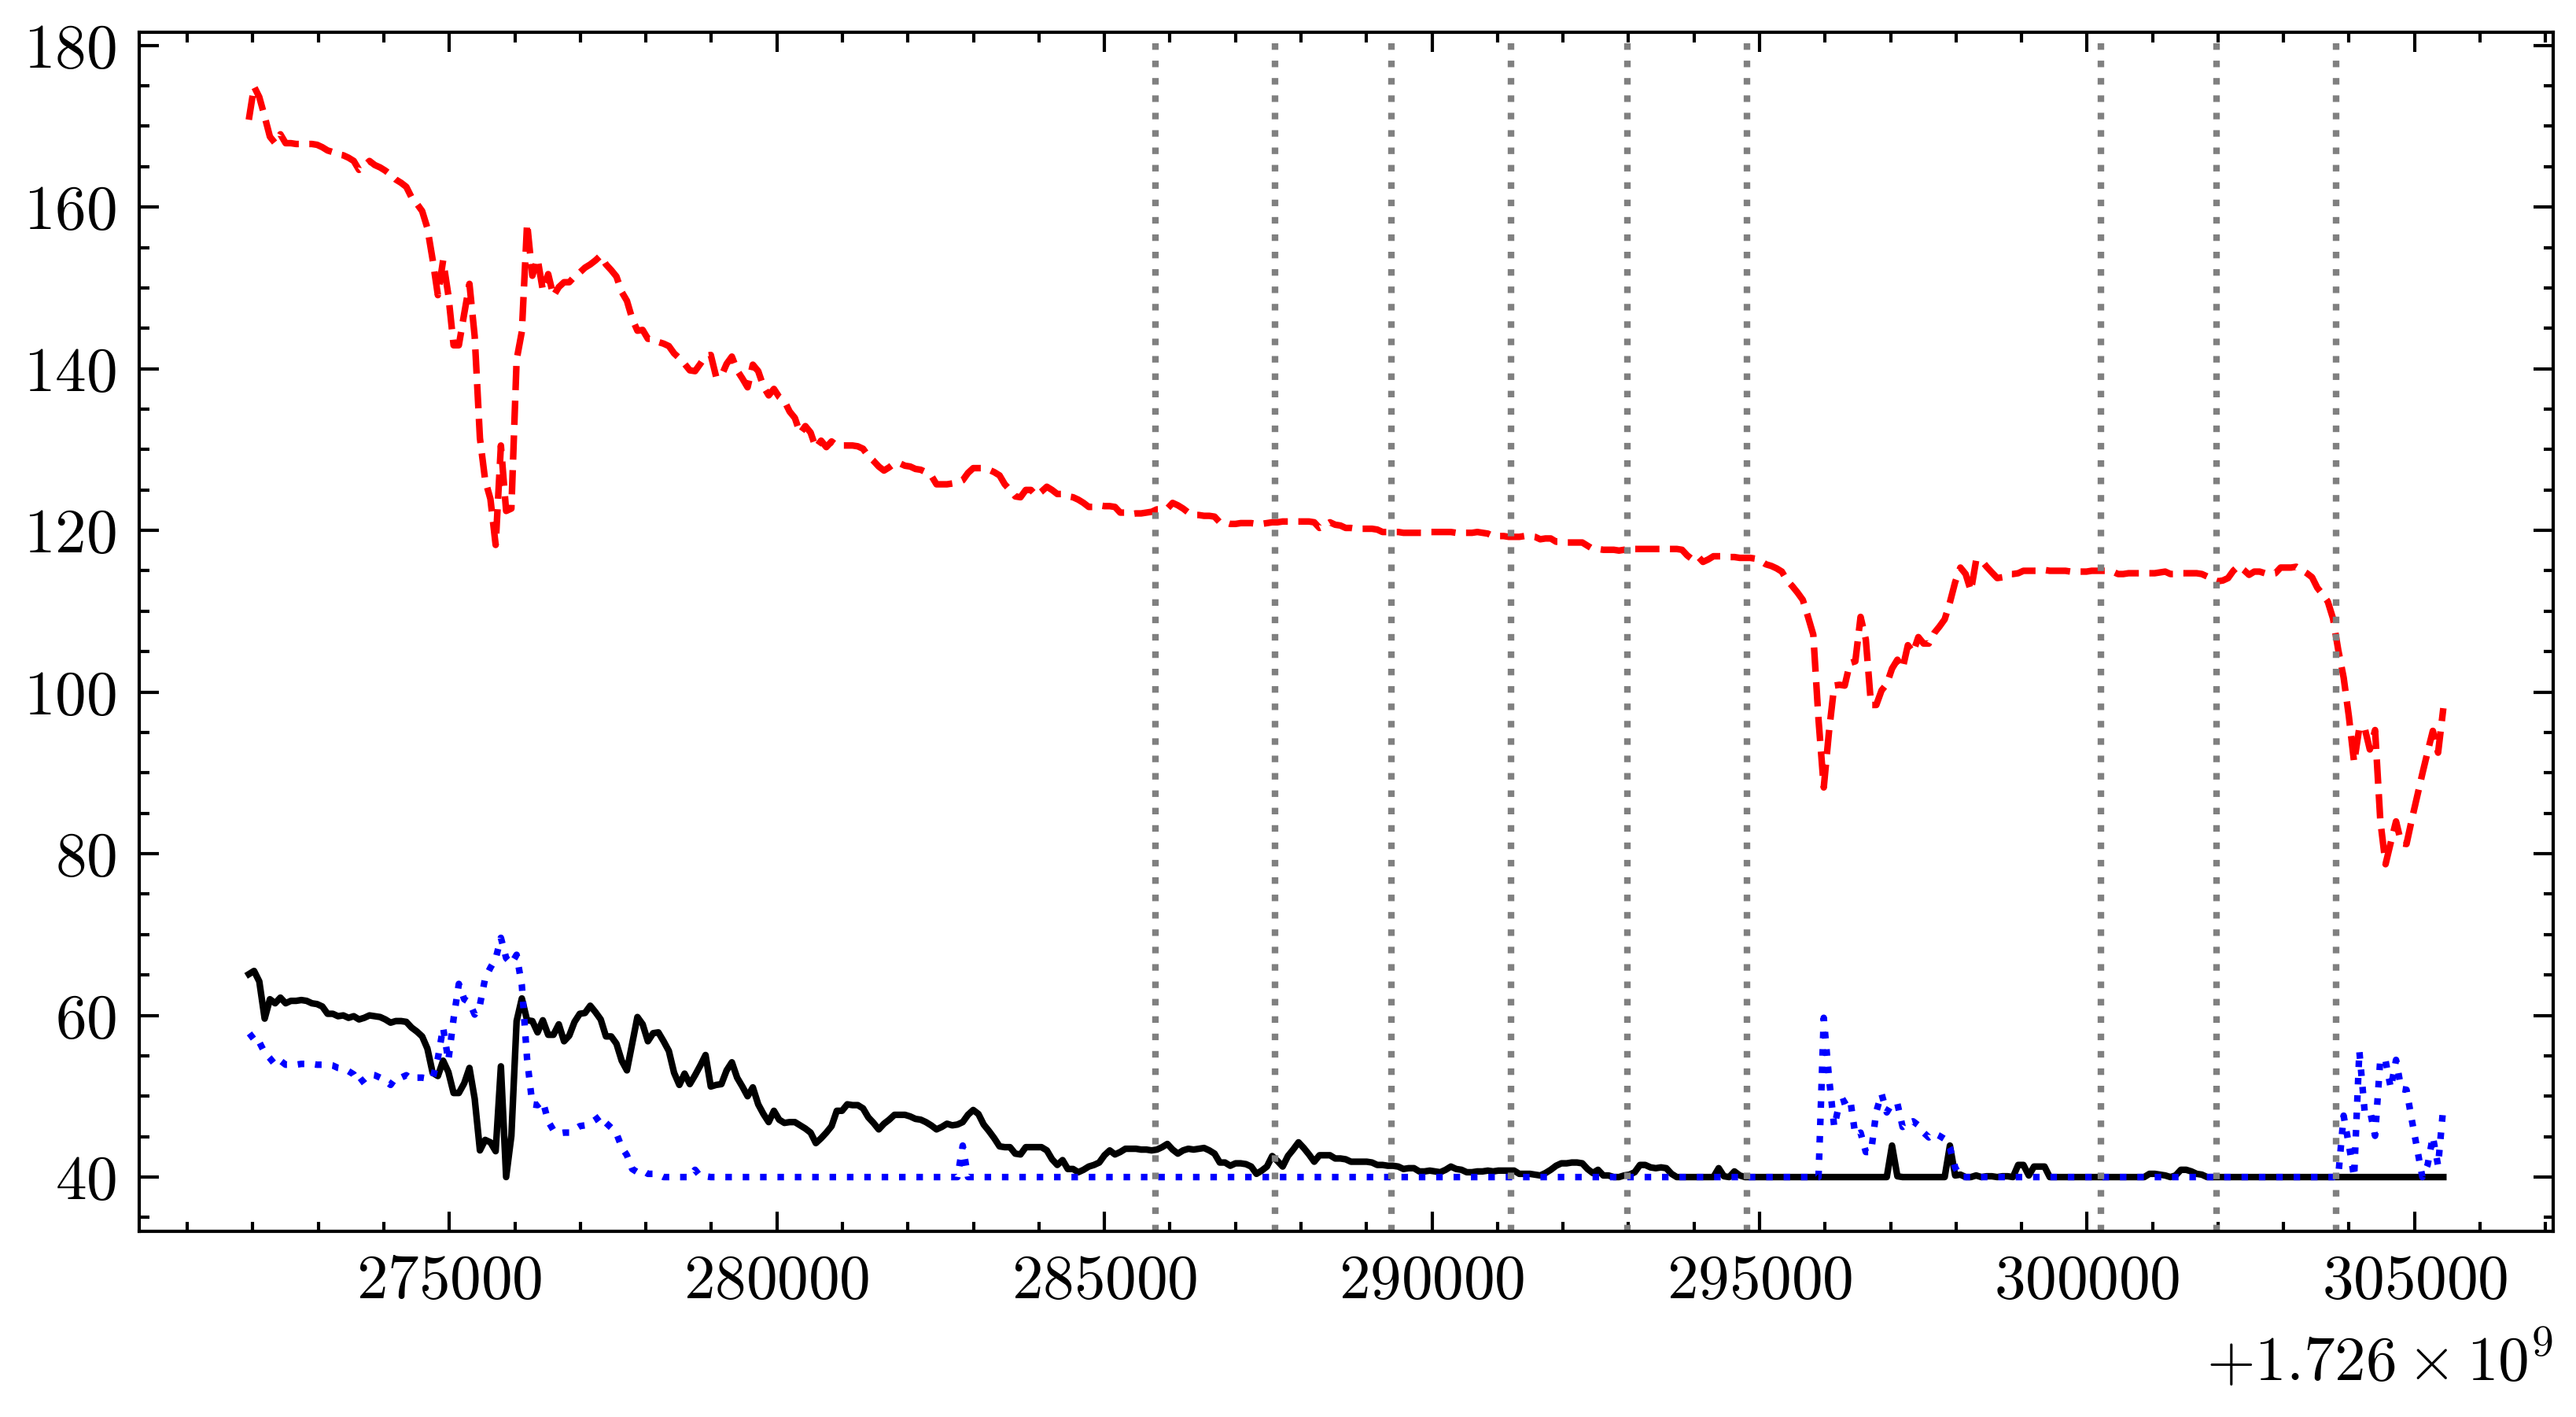

In [9]:
from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

id, time, *histo = np.loadtxt('out.txt', unpack=True)
plt.plot(t[mask], vem[mask])

for ts in time:
    plt.axvline(ts + CONSTANTS.GPS_OFFSET, c='gray', ls=':')

In [6]:
from utils.binaries import *

print(np.std(t70[mask], axis=0))


[10.984172   7.5615582  6.013472 ]


In [7]:
import uproot

events = uproot.open('/cr/data01/filip/Data/daqIntegrationTests/v13/sd_2024_09_14_01h20.root')
print(events.keys())

['44#0#RANDOM#1410313830#1;1', '45#0#RANDOM#1410315631#1;1', '46#0#RANDOM#1410317436#1;1', '47#0#RANDOM#1410319237#1;1', '48#0#RANDOM#1410321038#1;1', '49#0#RANDOM#1410322839#1;1', '50#0#RANDOM#1410324640#1;1', '51#0#RANDOM#1410326441#1;1', '52#0#RANDOM#1410328242#1;1', '53#0#RANDOM#1410330043#1;1', '54#0#RANDOM#1410331844#1;1', '55#0#RANDOM#1410333645#1;1', '56#0#RANDOM#1410335446#1;1', '57#0#RANDOM#1410337247#1;1', '58#0#RANDOM#1410339048#1;1', 'IoSdHeader;1']
